In [1]:
import argparse
import datetime
import math
import os
import sys
import random
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
sys.path.append('/data2/youngju/kimst24')

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import datasets, models, transforms
from tqdm.auto import tqdm
from utils.load_dataset import get_CUB_loaders
from utils.config_funcs import *
from utils.visualization import *

/home/youngju/anaconda3/envs/proto/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--data-path", type=str, default="/data/CUB_200_2011/images")
parser.add_argument("--model-path", type=str, default="/data2/youngju/kimst24/outputs_backup/clf_checkpoints/2024-05-01_204226/clf_ep-24_lr-0.001_val-acc-0.7630.pth")
parser.add_argument("--pickle-path", type=str, default="/data2/youngju/kimst24/outputs/get_config/train")
parser.add_argument("--q_pickle-path", type=str, default="/data2/youngju/kimst24/outputs/get_config/test")
parser.add_argument("--q_th", type=int, default=30000)
parser.add_argument("--seed", type=int, default=0)
parser.add_argument("--batch-size", type=int, default=512)
parser.add_argument("--num-pickle", type=int, default=7)
parser.add_argument("--device", type=str, default="cuda:5")
parser.add_argument("--train-ratio", type=float, default=0.7)

args = parser.parse_args(args=[])

In [3]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
unorm = UnNormalize(mean=MEAN, std=STD)

random.seed(args.seed)
torch.manual_seed(args.seed)
cudnn.deterministic = True
cudnn.benchmark = False

# (train_loader, train_data_len) = get_CUB_loaders(args.data_path, args.batch_size, args.train_ratio, train=True)
# (val_loader, test_loader, valid_data_len, test_data_len) = get_CUB_loaders(args.data_path, int(args.batch_size/2), args.train_ratio, train=False)

In [4]:
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, 200)
model.load_state_dict(torch.load(args.model_path))
model = model.to(args.device)
model.eval()

/home/youngju/anaconda3/envs/proto/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/youngju/anaconda3/envs/proto/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
with open(f"{args.pickle_path}/total_activation.pkl","rb") as fr:
    ac_total = torch.sign(pickle.load(fr))
with open(f"{args.pickle_path}/total_eq.pkl","rb") as fr:
    eq_total = pickle.load(fr)
with open(f"{args.pickle_path}/total_x.pkl","rb") as fr:
    x_total = pickle.load(fr)
with open(f"{args.pickle_path}/total_y.pkl","rb") as fr:
    y_total = pickle.load(fr)
with open(f"{args.pickle_path}/total_preds.pkl","rb") as fr:
    preds_total = pickle.load(fr)

In [6]:
ac_total.shape, eq_total.shape, x_total.shape, y_total.shape

(torch.Size([8251, 2048, 7, 7]),
 torch.Size([8251]),
 torch.Size([8251, 3, 224, 224]),
 torch.Size([8251]))

In [7]:
with open(f"{args.q_pickle_path}/total_activation.pkl","rb") as fr:
    q_ac_total = torch.sign(pickle.load(fr))
with open(f"{args.q_pickle_path}/total_eq.pkl","rb") as fr:
    q_eq_total = pickle.load(fr)
with open(f"{args.q_pickle_path}/total_x.pkl","rb") as fr:
    q_x_total = pickle.load(fr)
with open(f"{args.q_pickle_path}/total_y.pkl","rb") as fr:
    q_y_total = pickle.load(fr)
with open(f"{args.q_pickle_path}/total_preds.pkl","rb") as fr:
    q_preds_total = pickle.load(fr)

In [8]:
q_ac_total.shape, q_eq_total.shape, q_x_total.shape, q_y_total.shape

(torch.Size([1769, 2048, 7, 7]),
 torch.Size([1769]),
 torch.Size([1769, 3, 224, 224]),
 torch.Size([1769]))

In [9]:
with open(f"{args.q_pickle_path}/q_ham_density_{args.q_th}.pkl","rb") as fr:
    q_density = pickle.load(fr)
with open(f"{args.q_pickle_path}/q_ham_n_nearest_y_{args.q_th}.pkl","rb") as fr:
    q_n_nearest_y = pickle.load(fr)

# Density 분포 확인

(array([732.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   5.,   4.,  22.,  36., 103.,  14.,
          0.,   0.,   0.,   0.,   2.,   0.,   1.,   2.,   6.,  11.,  19.,
         14.,  28.,  20.,  16.,  10.,   7.,   7.,   7.,  20.,  15.,  13.,
         20.,  10.,  10.,  14.,  14.,   9.,  12.,  18.,  11.,  15.,  15.,
         18.,  14.,  16.,  20.,  22.,  30.,  19.,  16.,  18.,  20.,  23.,
         16.,  24.,  18.,  23.,  21.,  20.,  17.,  24.,  37.,  19.,  10.,
         19.,   8.,  10.,   5.,   6.,   4.,   2.,   2.,   2.,   0.,   0.,
          3.]),
 array([    0.  ,   934.28,  1868.56,  2802.84,  3737.12,  4671.4 ,
         5605.68,  6539.96,  7474.24,  8408.52,  9342.8 , 10277.08,
        11211.36, 12145.64, 13079.92, 14014.2 , 14948.48, 15882.76,
        16817.04, 17751.32, 18685.6 , 19619.88, 20554.16, 21488.44,
        22422.72, 23357.  , 24291.28, 25225.56

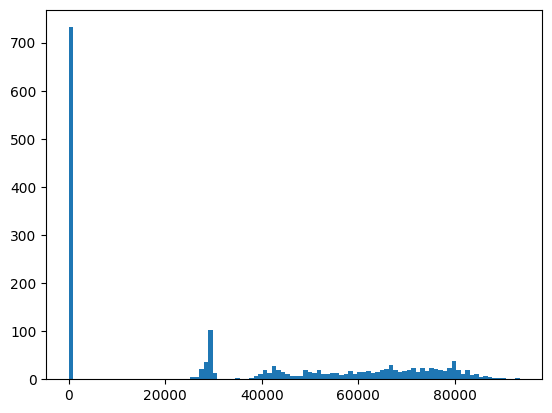

In [10]:
plt.hist(q_density, bins=100)

In [12]:
plt.boxplot(q_density)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb6bc052e80>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb6bc064400>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb6bc052be0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb6bc064940>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb6bc064be0>],
 'means': []}

In [13]:
# density - eq
plt.scatter(q_density, q_eq_total.tolist())
plt.ylabel('correct/wrong')
plt.xlabel('Density of the regions')

Text(0.5, 0, 'Density of the regions')

In [15]:
import scipy.stats as stats
stats.spearmanr(q_density,q_eq_total.tolist())

SignificanceResult(statistic=0.0907140679571534, pvalue=0.00013314413569259518)

Text(0.5, 0, 'Density of the regions')

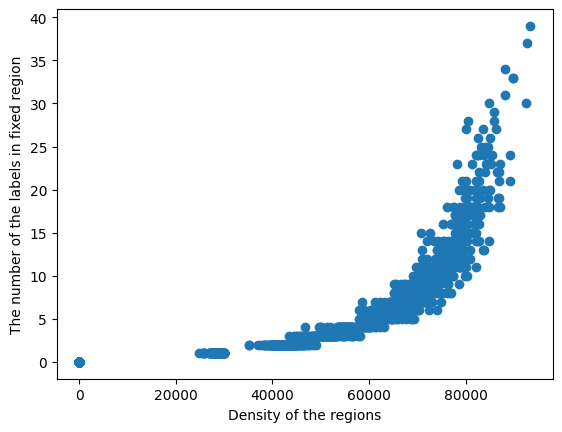

In [11]:
# density - the number of nearest y (label noise)
plt.scatter(q_density, q_n_nearest_y)
plt.ylabel('The number of the labels in fixed region')
plt.xlabel('Density of the regions')

# Low density region vs High density region

## Overall

In [12]:
num_zero = (np.array(q_density) == 0).sum()
num_zero

732

In [13]:
k = 32
low_density_idx = np.argsort(q_density)[:k].tolist()
high_density_idx = np.argsort(q_density)[-k:].tolist()

In [14]:
unorm = UnNormalize(mean=MEAN, std=STD)
low_den_samples = []
high_den_samples = []
for q_low_idx in low_density_idx:
    low_den_samples.append(unorm(q_x_total[q_low_idx]))
for q_high_idx in high_density_idx:
    high_den_samples.append(unorm(q_x_total[q_high_idx]))

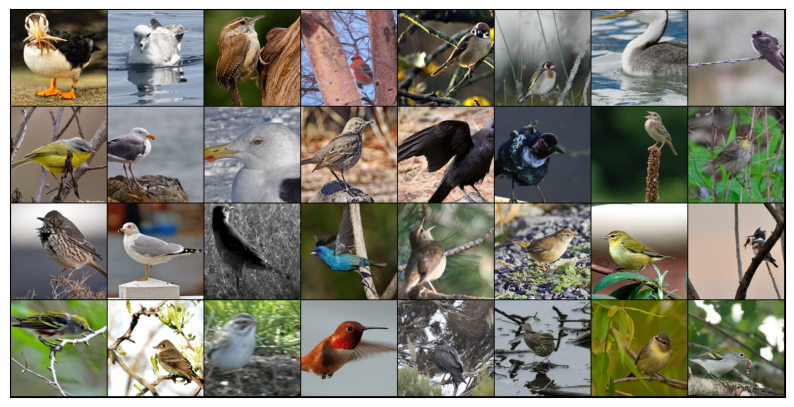

In [15]:
low_den_grid = make_grid(low_den_samples)
show(low_den_grid)

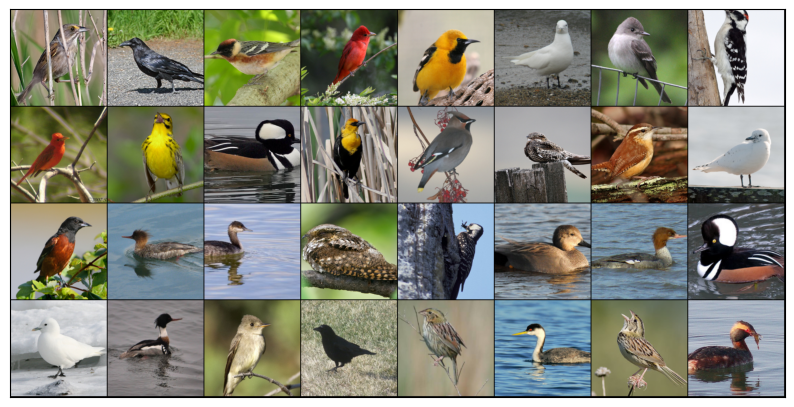

In [16]:
high_den_grid = make_grid(high_den_samples)
show(high_den_grid)

## 같은 label을 갖지만 region의 density 정도가 다른 경우 비교

(array([12., 11.,  7., 11.,  6.,  5.,  7., 11.,  7.,  9.,  6., 10., 10.,
        13.,  7., 10.,  2.,  6., 10.,  7., 12.,  9.,  7.,  7.,  7.,  7.,
         7., 10., 10.,  7.,  8.,  9., 12.,  7.,  9.,  6., 15.,  8.,  7.,
         9.,  9., 10., 10., 13.,  8.,  8.,  7.,  9., 12.,  7.,  4.,  9.,
         7.,  7., 10.,  6., 10.,  6., 12.,  9.,  9., 10.,  9.,  8.,  6.,
        14., 10.,  7., 10., 11.,  9.,  8.,  8.,  7., 16., 20., 12., 11.,
         8.,  9.,  7.,  5.,  6., 13., 10.,  8., 12., 15., 14.,  6., 11.,
        10.,  6.,  9.,  9., 11., 10., 12., 10., 10., 11.,  6.,  8.,  7.,
        13.,  7.,  9., 12.,  4.,  8.,  6.,  8.,  9.,  6.,  7., 19.,  8.,
         5.,  6., 10.,  7.,  8.,  9., 11., 10.,  6.,  4.,  8., 10., 10.,
        11.,  8.,  8.,  9., 12., 10., 12.,  8.,  7.,  6., 11., 10., 14.,
         5.,  8.,  7., 10.,  7.,  7., 10.,  6.,  6., 14., 11.,  6.,  7.,
         8.,  9.,  8., 10., 16.,  9., 11.,  9., 12.,  3., 10.,  8., 10.,
         8., 11.,  7.,  5.,  6., 11.,  9.,  8.,  5.

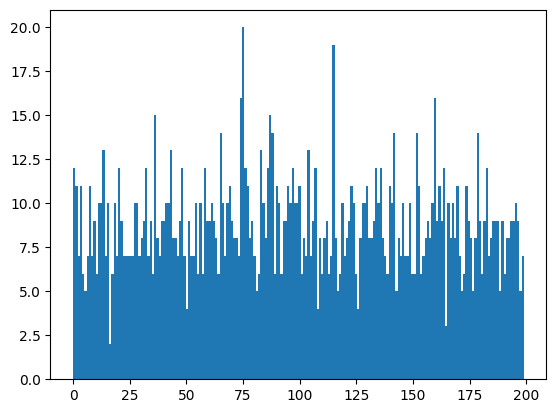

In [17]:
plt.hist(q_y_total, bins=200)

In [19]:
q_label = 0
q_label_samples = torch.where(q_y_total == q_label)[0].tolist()
for i in q_label_samples:
    print(f'{i}-th:       {q_density[i]}')

66-th:       0
109-th:       82068
243-th:       45603
569-th:       0
637-th:       29877
738-th:       52735
965-th:       0
1068-th:       41095
1077-th:       83744
1461-th:       29193
1479-th:       0
1517-th:       74022


label: 0, predictions: 0, 71


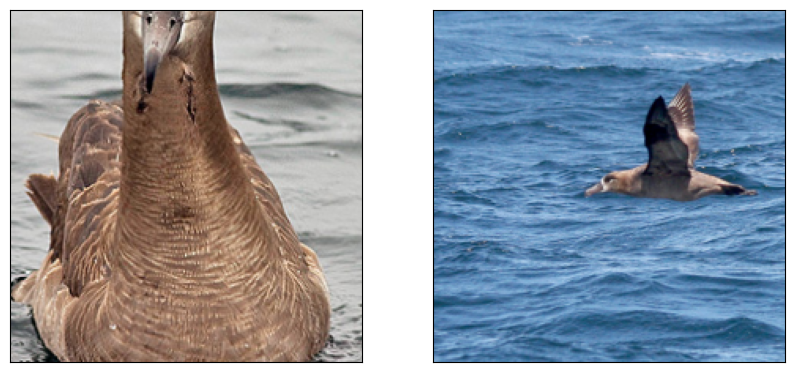

In [20]:
show_smaller([unorm(q_x_total[66]), unorm(q_x_total[109])])
print(f'label: {q_label}, predictions: {q_preds_total[66]}, {q_preds_total[109]}')

In [21]:
q_label = 2
q_label_samples = torch.where(q_y_total == q_label)[0].tolist()
for i in q_label_samples:
    print(f'{i}-th:       {q_density[i]}')

60-th:       68643
225-th:       74831
585-th:       28610
962-th:       25908
1224-th:       0
1600-th:       0
1662-th:       28196


label: 2, predictions: 32, 77


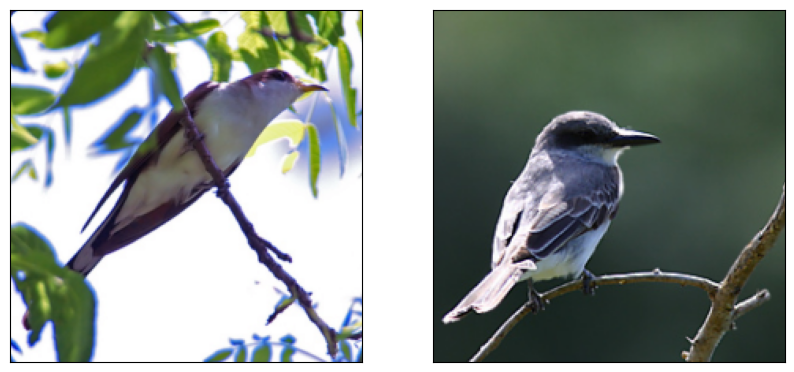

In [22]:
show_smaller([unorm(q_x_total[444]), unorm(q_x_total[744])])
print(f'label: {q_label}, predictions: {q_preds_total[444]}, {q_preds_total[744]}')

In [23]:
q_label = 145
q_label_samples = torch.where(q_y_total == q_label)[0].tolist()
for i in q_label_samples:
    print(f'{i}-th:       {q_density[i]}')

275-th:       27469
509-th:       78077
583-th:       66865
752-th:       41739
858-th:       0
945-th:       48924
1456-th:       59610


label: 145, predictions: 65, 95


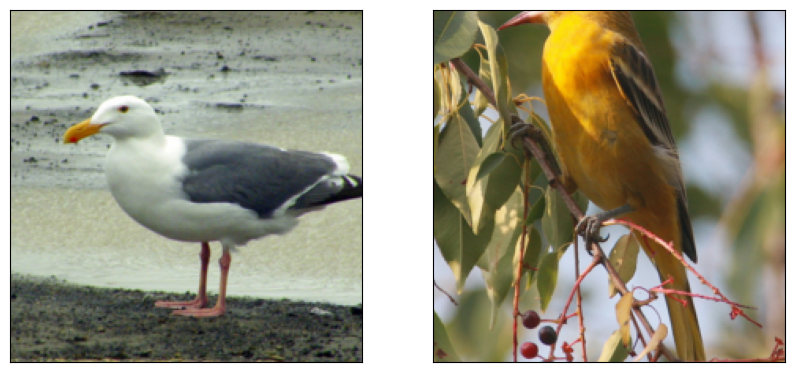

In [24]:
show_smaller([unorm(q_x_total[950]), unorm(q_x_total[923])])
print(f'label: {q_label}, predictions: {q_preds_total[950]}, {q_preds_total[923]}')

In [25]:
q_label = 197
q_label_samples = torch.where(q_y_total == q_label)[0].tolist()
for i in q_label_samples:
    print(f'{i}-th:       {q_density[i]}')

45-th:       0
484-th:       0
517-th:       66382
592-th:       57825
613-th:       61639
745-th:       28855
1172-th:       0
1285-th:       82523
1403-th:       0


label: 197, predictions: 196, 21, 74, 90


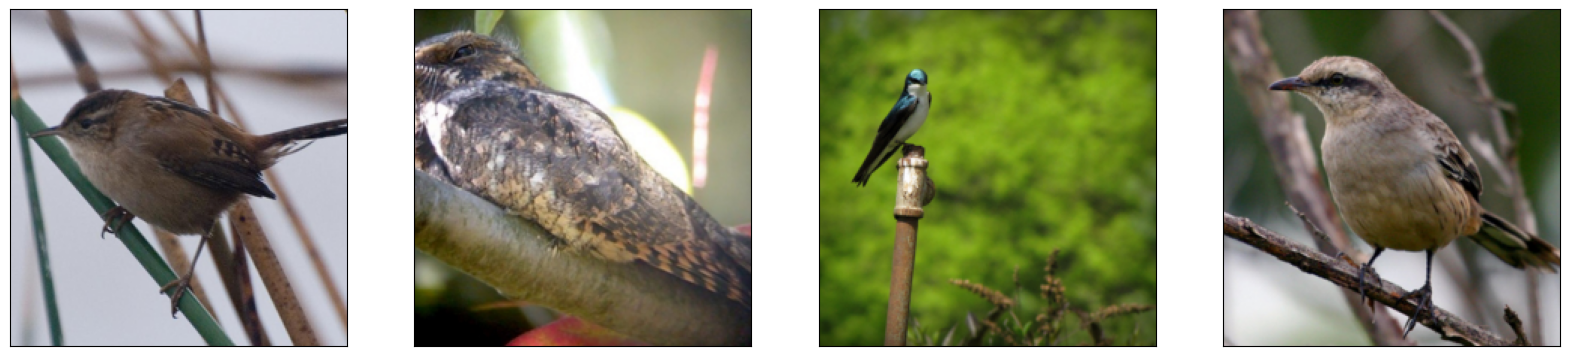

In [26]:
show_smaller([unorm(q_x_total[5]), unorm(q_x_total[655]), unorm(q_x_total[925]), unorm(q_x_total[1317])]) # 948: wrong prediction
print(f'label: {q_label}, predictions: {q_preds_total[5]}, {q_preds_total[655]}, {q_preds_total[925]}, {q_preds_total[1317]}')

## 같은 prediction을 갖지만 region의 density 정도가 다른 경우 비교

(array([11.,  8.,  8.,  9.,  5.,  2.,  9., 11.,  8.,  8.,  8.,  9., 12.,
        14.,  7.,  9.,  3.,  6.,  9.,  9., 10., 18.,  5., 10.,  5.,  9.,
         8., 18.,  7., 18., 15.,  8., 15.,  7., 11.,  6.,  9.,  9.,  6.,
         7.,  6., 11.,  6., 11.,  8.,  6.,  8.,  8.,  6.,  8.,  4.,  7.,
         6.,  8., 11.,  6., 11.,  5., 11.,  4., 10.,  6., 10.,  8.,  9.,
        20., 11.,  8.,  9., 11.,  9., 14.,  7.,  7., 18., 21., 10.,  8.,
         8.,  8.,  6.,  2.,  6., 12., 10.,  8., 12., 13., 13.,  6., 14.,
        10.,  7., 10.,  7., 13., 13., 15.,  8., 13.,  8., 11., 13.,  8.,
         3.,  6., 10.,  8.,  5.,  8.,  4., 10.,  8.,  7.,  6., 10.,  7.,
         9.,  8., 10.,  9.,  8.,  9., 12., 13.,  5.,  7.,  6.,  6., 14.,
         9.,  9.,  6.,  7., 10., 12.,  9.,  7.,  7.,  6.,  4., 11., 12.,
        10., 13.,  8.,  7.,  5., 11., 13.,  7.,  6., 11.,  6., 11., 11.,
        10.,  7.,  8., 11., 16.,  9., 12.,  7.,  9.,  2.,  2., 11.,  6.,
         7.,  8., 10.,  5.,  6., 11.,  8.,  9.,  3.

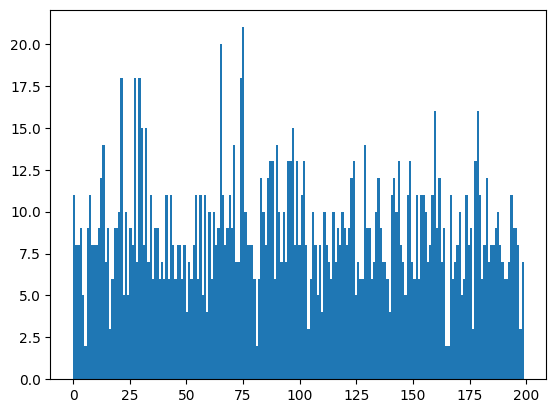

In [27]:
plt.hist(q_preds_total.cpu().detach(), bins=200)

In [28]:
q_pred = 5
q_pred_samples = torch.where(q_preds_total == q_pred)[0].tolist()
for i in q_pred_samples:
    print(f'{i}-th:       {q_density[i]}')

379-th:       71397
656-th:       41376


label: 105, 156, predictions: 5


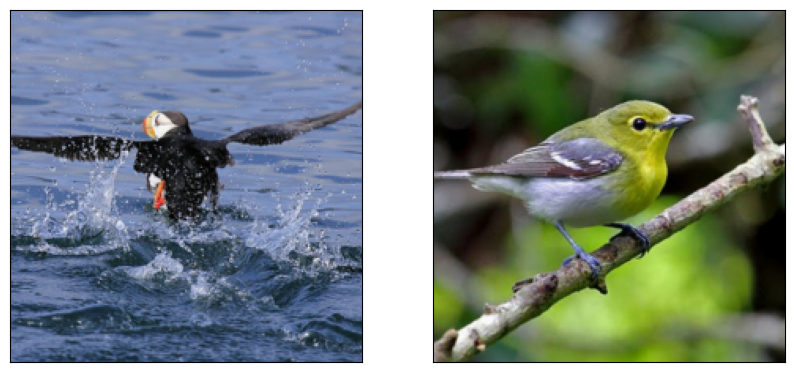

In [29]:
show_smaller([unorm(q_x_total[111]), unorm(q_x_total[1708])])
print(f'label: {q_y_total[111]}, {q_y_total[1708]}, predictions: {q_pred}')

In [30]:
q_pred = 191
q_pred_samples = torch.where(q_preds_total == q_pred)[0].tolist()
for i in q_pred_samples:
    print(f'{i}-th:       {q_density[i]}')

158-th:       82901
248-th:       84986
267-th:       0
525-th:       0
1139-th:       78663
1679-th:       62176


label: 54, 131, 174, 63, predictions: 191


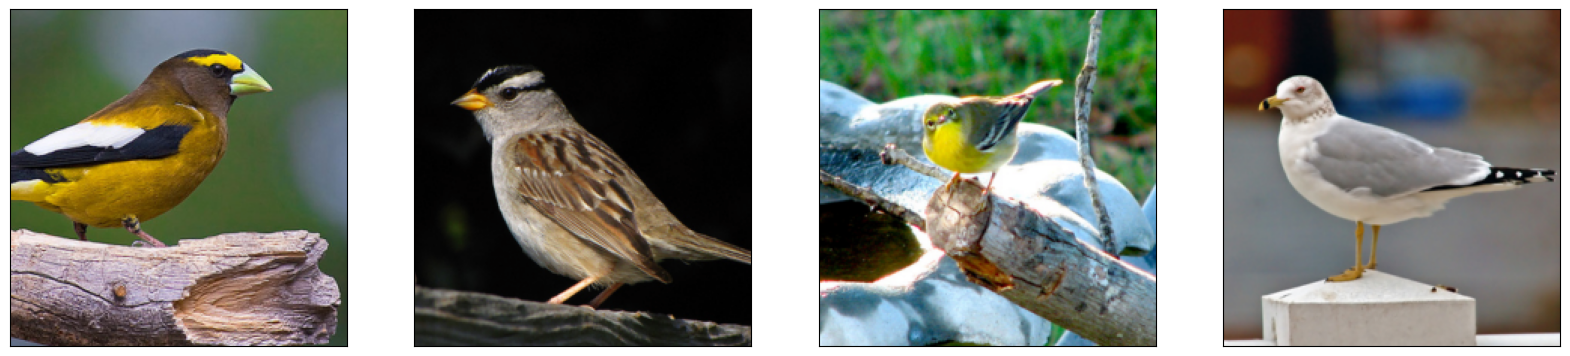

In [31]:
show_smaller([unorm(q_x_total[490]), unorm(q_x_total[1053]), unorm(q_x_total[957]), unorm(q_x_total[630])])
print(f'label: {q_y_total[490]}, {q_y_total[1053]}, {q_y_total[957]}, {q_y_total[630]}, predictions: {q_pred}')

## Region 관찰 (query 이미지를 중심으로)

### High-density region

In [32]:
high_density_idx[:3]

[746, 924, 1515]

In [33]:
k = 31
h_idx = 965
local_nearest_idx, local_nearest_dist = get_local_nearest_ham_and_idx(q_ac_total[h_idx], ac_total, th=args.q_th)
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[h_idx])]
label_list = [q_y_total[h_idx].item()]
preds_list = [q_preds_total[h_idx].item()]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
    label_list.append(y_total[local_nearest_idx[sorted_idx[i]]].item())
    preds_list.append(preds_total[local_nearest_idx[sorted_idx[i]]].item())
grid = make_grid(img_list)
show(grid)
print(f'label: {label_list}')
print(f'preds: {preds_list}')

IndexError: index 0 is out of bounds for axis 0 with size 0

label: [58, 58, 58, 58, 63, 63, 59, 61, 63, 61, 58, 58, 58, 59, 61, 62, 61, 63, 58, 63, 63, 58, 58, 63, 58, 63, 59, 58, 63, 146, 59, 58]
preds: [58, 58, 63, 58, 62, 63, 58, 63, 63, 63, 58, 58, 63, 59, 63, 62, 61, 63, 58, 63, 63, 58, 58, 63, 58, 63, 59, 58, 63, 63, 58, 65]


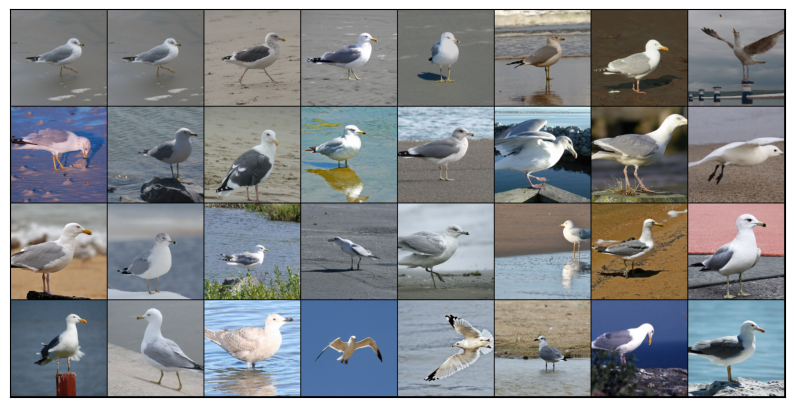

In [ ]:
k = 31
h_idx = 217
local_nearest_idx, local_nearest_dist = get_local_nearest_ham_and_idx(q_ac_total[h_idx], ac_total, th=args.q_th)
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[h_idx])]
label_list = [q_y_total[h_idx].item()]
preds_list = [q_preds_total[h_idx].item()]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
    label_list.append(y_total[local_nearest_idx[sorted_idx[i]]].item())
    preds_list.append(preds_total[local_nearest_idx[sorted_idx[i]]].item())
grid = make_grid(img_list)
show(grid)
print(f'label: {label_list}')
print(f'preds: {preds_list}')

label: [29, 29, 106, 28, 106, 106, 28, 29, 29, 106, 106, 107, 29, 28, 106, 29, 26, 28, 28, 29, 107, 29, 29, 29, 26, 29, 106, 29, 28, 107, 29, 28]
preds: [29, 29, 106, 28, 106, 106, 29, 29, 106, 106, 28, 107, 29, 28, 106, 29, 29, 28, 28, 28, 107, 106, 28, 29, 26, 29, 106, 28, 28, 29, 107, 28]


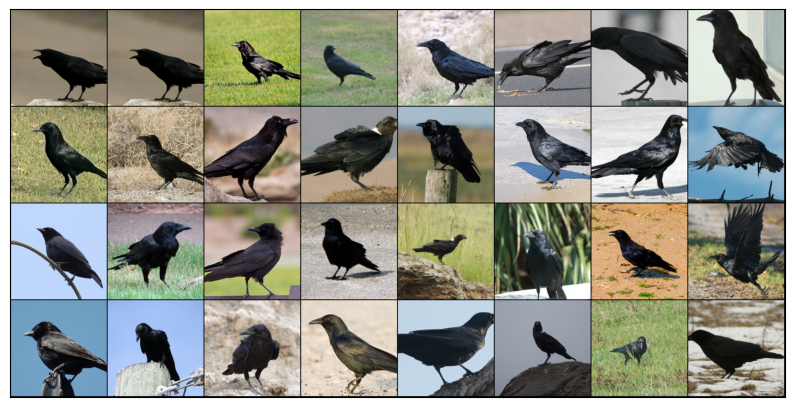

In [ ]:
k = 31
h_idx = 964
local_nearest_idx, local_nearest_dist = get_local_nearest_ham_and_idx(q_ac_total[h_idx], ac_total, th=args.q_th)
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[h_idx])]
label_list = [q_y_total[h_idx].item()]
preds_list = [q_preds_total[h_idx].item()]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
    label_list.append(y_total[local_nearest_idx[sorted_idx[i]]].item())
    preds_list.append(preds_total[local_nearest_idx[sorted_idx[i]]].item())
grid = make_grid(img_list)
show(grid)
print(f'label: {label_list}')
print(f'preds: {preds_list}')

### Low-density region

In [ ]:
low_density_idx[:3]

[1199, 491, 888]

In [ ]:
q_density[1199]

0

### Mid-density region

In [ ]:
np.where((40000<np.array(q_density)) & (np.array(q_density)<45000))[0]

array([   0,    6,   15,   22,   26,   38,   40,   70,   77,   83,  104,
        117,  129,  136,  143,  148,  150,  155,  161,  169,  228,  292,
        316,  322,  327,  389,  405,  454,  467,  497,  509,  519,  521,
        533,  535,  568,  583,  584,  611,  632,  636,  637,  648,  678,
        684,  698,  709,  712,  716,  723,  734,  742,  863,  869,  887,
        933,  946,  953,  956,  971,  978,  981,  987,  989, 1002, 1015,
       1022, 1028, 1060, 1077, 1088, 1119, 1140, 1141, 1143, 1183, 1186,
       1193, 1211, 1216, 1225, 1226, 1227, 1255, 1270, 1274, 1278, 1284,
       1288, 1303, 1304, 1338, 1360, 1370, 1401, 1452, 1464, 1477, 1578,
       1591, 1670, 1690, 1728, 1740, 1751, 1755, 1768])

label: [87, 87, 87]
preds: [87, 87, 87]


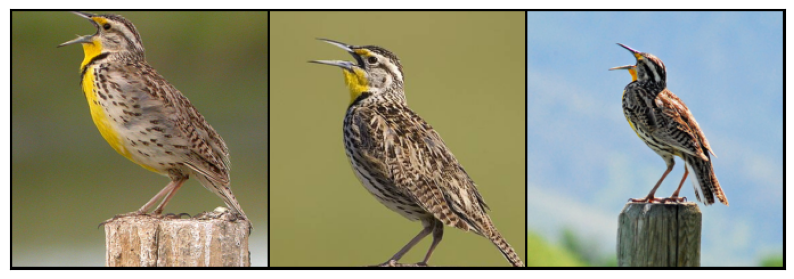

In [ ]:
m_idx = 0
local_nearest_idx, local_nearest_dist = get_local_nearest_ham_and_idx(q_ac_total[m_idx], ac_total, th=args.q_th)
k = len(local_nearest_idx)
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[m_idx])]
label_list = [q_y_total[m_idx].item()]
preds_list = [q_preds_total[m_idx].item()]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
    label_list.append(y_total[local_nearest_idx[sorted_idx[i]]].item())
    preds_list.append(preds_total[local_nearest_idx[sorted_idx[i]]].item())
grid = make_grid(img_list)
show(grid)
print(f'label: {label_list}')
print(f'preds: {preds_list}')

label: [72, 72, 72]
preds: [72, 72, 72]


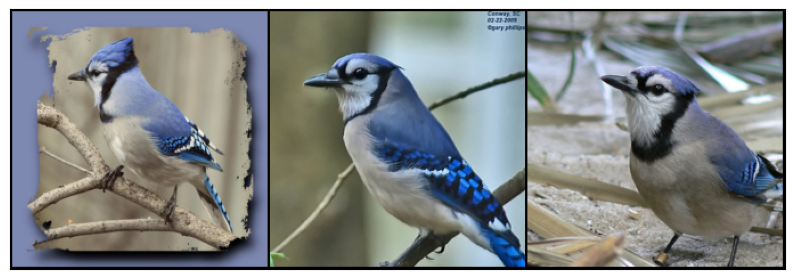

In [ ]:
m_idx = 1278
local_nearest_idx, local_nearest_dist = get_local_nearest_ham_and_idx(q_ac_total[m_idx], ac_total, th=args.q_th)
k = len(local_nearest_idx)
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[m_idx])]
label_list = [q_y_total[m_idx].item()]
preds_list = [q_preds_total[m_idx].item()]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
    label_list.append(y_total[local_nearest_idx[sorted_idx[i]]].item())
    preds_list.append(preds_total[local_nearest_idx[sorted_idx[i]]].item())
grid = make_grid(img_list)
show(grid)
print(f'label: {label_list}')
print(f'preds: {preds_list}')

label: [160, 160, 160]
preds: [160, 160, 160]


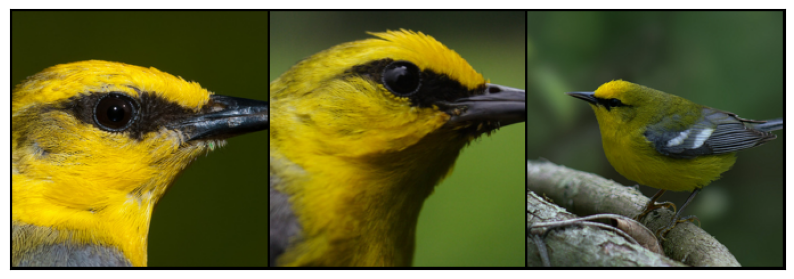

In [34]:
m_idx = 1288
local_nearest_idx, local_nearest_dist = get_local_nearest_ham_and_idx(q_ac_total[m_idx], ac_total, th=args.q_th)
k = len(local_nearest_idx)
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[m_idx])]
label_list = [q_y_total[m_idx].item()]
preds_list = [q_preds_total[m_idx].item()]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
    label_list.append(y_total[local_nearest_idx[sorted_idx[i]]].item())
    preds_list.append(preds_total[local_nearest_idx[sorted_idx[i]]].item())
grid = make_grid(img_list)
show(grid)
print(f'label: {label_list}')
print(f'preds: {preds_list}')

# Accuracy와의 관계

In [35]:
for i in range(0,100000,25000):
    q_idx_range = np.where((i<=np.array(q_density)) & (np.array(q_density)<(i+25000)))[0]
    acc = np.sum(np.array(q_eq_total)[q_idx_range])/len(q_idx_range)
    print(f'{i}~{i+25000}:        {acc}')
    print(f'개수:                  {len(q_idx_range)}')

0~25000:        0.5879945429740792
개수:                  733
25000~50000:        0.8066298342541437
개수:                  362
50000~75000:        0.8797327394209354
개수:                  449
75000~100000:        0.92
개수:                  225
